In [1]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

#mean squared error, mean absolute error, and coefficient of determination
import lcpfn.lcpfn as lcpfn

path_all = '/mnt/c/Users/prath/PycharmProjects/rp/LCDB_localised/all_curves_preprocessed.pkl'
df_all = pd.read_pickle(path_all)

# model_name = '/mnt/c/Users/prath/PycharmProjects/rp/Data/model_lcdb_2.pt'
model_name = None
if model_name is None:
    model = lcpfn.LCPFN()
else:
    model = lcpfn.LCPFN(model_name=model_name)
print(model_name)

None


In [16]:
#vairables
CUTOFF = 10 #percentage of the curve use as input
FAIL_PER = 60 #percentage of points that should be within the CI

## Check for which curves the lcpfn model is not able to predict

In [17]:
def get_curve(i:int):
    """Retrieve the curve for a given model and dataset."""
    row = df_all.iloc[i]
    openlid = row['openmlid']
    learner = row['learner']
    anchors = row['anchors']
    means = row['means']
    std = row['std']
    return anchors, means, std, openlid, learner

def get_closest_index(lst, target):
    return min(range(len(lst)), key=lambda i: abs(lst[i] - target))

def get_common_data(cutoff, anchors, means, ):
    means = np.array(means)
    anchors = np.array(anchors)
    anchors = ((anchors - np.min(anchors)) / (np.max(anchors) - np.min(anchors))) * 100

    cutoff_index = get_closest_index(anchors, cutoff)
    curve = np.array(means[:cutoff_index])
    anchors = anchors.astype(int)

    x = torch.from_numpy(anchors).unsqueeze(1)
    y = torch.from_numpy(curve).float().unsqueeze(1)
    return x, y, anchors, means, cutoff_index

def plot_it(anchors, means, predictions, cutoff_index, x, learner):
    plt.plot(anchors, means, "*", label="target")
    plt.plot(anchors, means, label="target")
    plt.plot(x[cutoff_index:], predictions[:, 1], "r*", label="Extrapolation by PFN")
    plt.fill_between(
        x[cutoff_index:].flatten(), predictions[:, 0], predictions[:, 2], color="red", alpha=0.3, label="CI of 90%"
    )
    plt.vlines(x[cutoff_index], 0, 1, linewidth=0.5, color="k", label="cutoff")
    plt.ylim(0, 1)
    plt.legend(loc="lower right")
    plt.savefig("/mnt/c/Users/prath/PycharmProjects/rp/Data/extrapolation_"+learner+".png")
    plt.show()

3 44 SVC_sigmoid 2 7


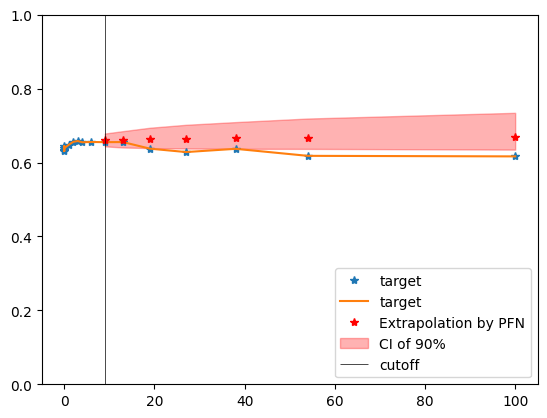

In [20]:
curve_that_failed = []
for i in range(len(df_all)):
    a, m, std, openlid, learner = get_curve(i)
    x, y, anchors, means, cutoff_index = get_common_data(CUTOFF, a, m)
    predictions = model.predict_quantiles(x_train=x[:cutoff_index], y_train=y, x_test=x[cutoff_index:], qs=[0.05, 0.5, 0.95])
    predictions = predictions.detach().numpy()
    low_ci = predictions[:, 0]
    high_ci = predictions[:, 2]

    #check if X% of points are within the CI
    conditions = (means[cutoff_index:] >= low_ci) & (means[cutoff_index:] <= high_ci)
    within_ci = np.where(conditions)[0]


    if len(within_ci) < FAIL_PER/100 * len(means[cutoff_index:]):
        curve_that_failed.append((i, openlid, learner, len(within_ci), len(means[cutoff_index:])))
        print(i, openlid, learner, len(within_ci), len(means[cutoff_index:]))
        plot_it(anchors, means, predictions, cutoff_index, x, learner)
        # print("---------------------------------------------------")
        break

In [19]:
print(len(curve_that_failed))
df = pd.DataFrame(curve_that_failed, columns=['index', 'openmlid', 'learner', 'within_ci', 'total'])
df['learner'].value_counts()

443


learner
SVC_sigmoid                                                    71
sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis    59
SVC_rbf                                                        34
SVC_poly                                                       33
sklearn.neural_network.MLPClassifier                           26
sklearn.linear_model.Perceptron                                24
sklearn.linear_model.RidgeClassifier                           20
sklearn.linear_model.PassiveAggressiveClassifier               19
sklearn.naive_bayes.BernoulliNB                                19
sklearn.linear_model.SGDClassifier                             18
sklearn.discriminant_analysis.LinearDiscriminantAnalysis       17
SVC_linear                                                     17
sklearn.ensemble.ExtraTreesClassifier                          16
sklearn.ensemble.RandomForestClassifier                        14
sklearn.neighbors.KNeighborsClassifier                         14
sk